In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pdb

In [2]:
data = pd.read_csv("stage_2_train_labels.csv")

In [18]:
data.patientId.unique().shape

(26684,)

In [5]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import pydicom
import os
import numpy as np
from matplotlib import pyplot, cm

In [24]:
data[data.patientId == "002c591d-df62-4e34-8eda-838c664430a9"]



,patientId,x,y,width,height,Target
29003,002c591d-df62-4e34-8eda-838c664430a9,NaN,NaN,NaN,NaN,0


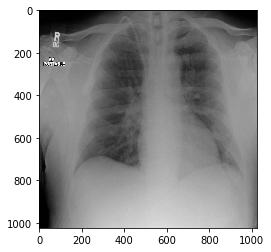

In [25]:
from pydicom import dcmread

fpath = f"./train_images/002c591d-df62-4e34-8eda-838c664430a9.dcm"
ds = dcmread(fpath)





# plot the image using matplotlib
plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
plt.show()

In [6]:


im = Image.fromarray(ds.pixel_array)

In [9]:
data.patientId.unique()

array(['0004cfab-14fd-4e49-80ba-63a80b6bddd6',
       '00313ee0-9eaa-42f4-b0ab-c148ed3241cd',
       '00322d4d-1c29-4943-afc9-b6754be640eb', ...,
       'c1edf42b-5958-47ff-a1e7-4f23d99583ba',
       'c1f6b555-2eb1-4231-98f6-50a963976431',
       'c1f7889a-9ea9-4acb-b64c-b737c929599a'], dtype=object)

In [66]:

class dataset(Dataset):
    """
    RSNA dataset
    """
    def __init__(self, ids, labels, transforms= None):
        self.ids = ids
        self.labels = labels
        self.transforms = transforms
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, index):
        pass
    def getImage(self, index):
        # make the path 
        path = f"./train_images/{self.ids[index]}.dcm"
        ds = dcmread(path)
        im = Image.fromarray(ds.pixel_array)
        return im
    def getTarget(self, index):
        target = {"boxes" : [], "labels" : [], "area" : []}
        for _, row in self.labels[self.labels.patientId == self.ids[index]].iterrows():
           
            patientID, x,y,h,w,label = row
            if not pd.isnull(x):
                target["boxes"].append([x,y, x + w, y+h ])
                target["labels"].append(label)
                target["area"].append(w*h)
                
        
        
        
        target["labels"] = torch.tensor(target["labels"])
        target["boxes"] = torch.tensor(target["boxes"]).float()
        N = target["boxes"].shape[0]
        if N > 0 :
            target["image_id"] = torch.tensor([index])
        else : 
            target["image_id"] = torch.tensor([])
        target["iscrowd"] = torch.zeros((N,), dtype=torch.int64)
        target["area"] = torch.tensor(target["area"])
        return target
    def __getitem__(self, index):
        img = self.getImage(index)
        target = self.getTarget(index)
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
        

In [67]:
DS = dataset(data.patientId.unique(), data)

In [69]:
DS[4]

(<PIL.Image.Image image mode=L size=1024x1024 at 0x7F9D27B31FD0>,
 {'boxes': tensor([[ 264.,  152.,  643.,  365.],
          [ 562.,  152., 1015.,  408.]]),
  'labels': tensor([1, 1]),
  'area': tensor([ 80727., 115968.]),
  'image_id': tensor([4]),
  'iscrowd': tensor([0, 0])})

In [87]:
notes = pd.read_csv("AMAL.csv", sep=",")

,Unnamed: 0,numero,projet,tme,Exam,Note Finale,rank,Nom,Prenom
26,26,28713967,16.0,14.0,9.0,12.6,41.0,DONZIER,PAUL
27,27,28720085,13.0,13.0,11.5,12.4,39.5,MEDEIROS CENTA,MATHEUS
28,28,3802781,17.0,13.0,8.5,12.4,39.5,KACI,RYM
29,29,28705410,12.0,13.0,12.0,12.3,37.5,FLORES,PEDRO
30,30,28615295,13.0,14.0,10.5,12.3,37.5,LEMERLE,THEODOR
31,31,3803464,13.0,15.0,9.5,12.2,36.0,SIDHOUM,IMAD
32,32,3775613,14.0,13.0,10.0,12.1,34.5,LAM,LISA
33,33,28717413,14.0,13.0,10.0,12.1,34.5,YAICI,MOULOUD RIADH
34,34,28709765,14.0,14.0,9.0,12.0,32.5,QUELENNEC,AEL
35,35,16003610,17.0,13.0,7.5,12.0,32.5,SALAIS,LEANE
